# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
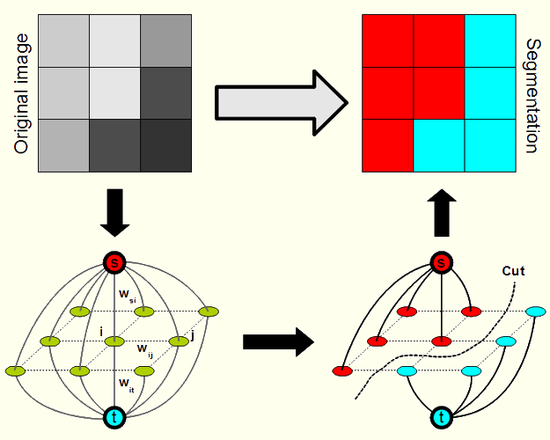

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
# !pip3 install python-igraph
# !pip install Pymaxflow

In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
import cv2
import string, os
from sklearn.mixture import GaussianMixture
from igraph import Graph
from copy import deepcopy
import maxflow

In [9]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = True
                self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = False
                self.FLAGS['rect_over'] = True
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0
        
        # Draw strokes for refinement 
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

### Sequential Version
    foreground:1
    background:0

In [10]:
def pixel_to_pixel_weight(m, n, zm, zn, beta=0.7, gamma=500):
    return gamma * np.exp((-beta) * np.linalg.norm(zm - zn)**2) / np.linalg.norm(m - n)

def source_sink_weight(gmm, m, zm, K):
    summation = 0
    for i in range(K):
        u = gmm.means_[i]
        p = gmm.weights_[i]
        cov = gmm.covariances_[i]
        determintant = np.linalg.det(cov)
        #print("det = ", determintant)
        inv_cov = np.linalg.inv(cov) #np.linalg.pin()
        #print("inv_cov", inv_cov)
        zu = zm - u
        normal = zu.T @ inv_cov @ zu
        #print(normal)
        summation += (p ) * np.exp(normal/2)
    #print(summation)
    return -np.log(summation)


def neighbours_weight(img, conn='c-4'):
    r, c, _ = img.shape
    KK = -100000
    edges_n_links = []
    for i in range(r-1):
        for j in range(c-1):
            index1 = i*c + j
            index2 = i*c + (j+1)
            m = np.array([i, j])
            n = np.array([i, j+1])
            w = pixel_to_pixel_weight(m, n, img[i][j], img[i][j+1])
            KK = max(KK, w)
            edges_n_links.append((index1,index2,w,w))

            index2 = (i+1)*c + j
            m = np.array([i, j])
            n = np.array([i+1, j])
            w = pixel_to_pixel_weight(m, n, img[i][j], img[i+1][j])
            KK = max(KK, w)
            edges_n_links.append((index1,index2,w,w))

            if(conn=='c-8'):
                index2 = (i+1)*c + (j+1)
                m = np.array([i, j])
                n = np.array([i+1, j+1])
                w = pixel_to_pixel_weight(m, n, img[i][j], img[i+1][j+1])
                KK = max(KK, w)
                edges_n_links.append((index1,index2,w,w))

    for i in range(r-1):
        j=c-1
        index1 = i*c + j
        index2 = (i+1)*c + j
        m = np.array([i, j])
        n = np.array([i+1, j])
        w = pixel_to_pixel_weight(m, n, img[i][j], img[i+1][j])
        KK = max(KK, w)
        edges_n_links.append((index1,index2,w,w))

    for j in range(c-1):
        i=r-1
        index1 = i*c + j
        index2 = i*c + (j+1)
        m = np.array([i, j])
        n = np.array([i, j+1])
        w = pixel_to_pixel_weight(m, n, img[i][j], img[i][j+1])
        KK = max(KK, w)
        edges_n_links.append((index1,index2,w,w))

    if(conn=='c-8'):
        for i in range(0, r-1):
            for j in range(1, c):
                index1 = i*c + j
                index2 = (i+1)*c + (j-1)
                m = np.array([i, j])
                n = np.array([i+1, j-1])
                w = pixel_to_pixel_weight(m, n, img[i][j], img[i+1][j-1])
                KK = max(KK, w)
                edges_n_links.append((index1,index2,w,w))
            
    return edges_n_links, KK


# edges_tlinks = []
# weights_tlinks = []
# DM1 = -gmm_bg.score_samples(fg).reshape((-1, 1))
# DM2 = -gmm_fg.score_samples(fg).reshape((-1, 1))
# count = 0
# r, c, _ = img.shape
# for i in range(r):
#     for j in range(c):
#         index = i*c + j
#         if(mask_temp[i][j]==1): #unknown
#             m = np.array([i, j])
#             zm = img[i][j]
#             Dm1 = source_sink_weight(gmm_fg, m, zm, K)
#             Dm2 = source_sink_weight(gmm_bg, m, zm, K)
#             print(Dm1, Dm2)
#             Dm1 =  DM1[count]
#             Dm2 =  DM2[count]
#             edges_tlinks.append([index, source])
#             edges_tlinks.append([index, sink])
#             weights_tlinks.append(Dm1)
#             weights_tlinks.append(Dm2)
#             count += 1
#         else: #bg
#             edges_tlinks.append([index, source])
#             edges_tlinks.append([index, sink])
#             weights_tlinks.append(0)
#             weights_tlinks.append(KK)

### Vectorised Version

### 4-Connected Neighbour

In [11]:
def Nlinks_4_neigh(img):
    h, w, _ = img.shape
    coords = np.arange(h*w).reshape((h, w))
    horizontal = np.concatenate((coords[:, 1:].reshape(-1, 1), coords[:, :-1].reshape(-1, 1)), axis=1)
    #print(horizontal.shape)
    vertical = np.concatenate((coords[1:, :].reshape(-1, 1), coords[:-1, :].reshape(-1, 1)), axis=1)
    #print(vertical.shape)

    edges_nlinks = np.vstack((horizontal, vertical))
    #print(edges_nlinks.shape)
    return edges_nlinks
    
def NlinksWeight_4_neigh(img, gamma = 50):
    h, w, _ = img.shape
    horizontal_edges = img[:, 1:] - img[:, :-1]
    #print(horizontal_edges.shape)
    vertical_edges = img[1:, :] - img[:-1, :]
    #print(vertical_edges.shape)
    
    horizontal_edges = horizontal_edges.reshape(-1, 3)
    vertical_edges = vertical_edges.reshape(-1, 3)

    weights_nlinks_ = np.vstack((horizontal_edges, vertical_edges))
    beta = calc_beta_4_neigh(img, weights_nlinks_)
    weights_nlinks = gamma * np.exp(-beta * np.sum(np.square(weights_nlinks_), axis=1))
    
    return weights_nlinks
    
    
# number of edges = (r-1)*c + r*(c-1)  
def calc_beta_4_neigh(img, weights_nlinks_):
    h, w, _ = img.shape
    weights_nlinks_sq = np.square(weights_nlinks_)
    sum_ = np.sum(weights_nlinks_sq)
    number_of_edges = h*(w-1) + (h-1)*w # horizonal edges + vertical_edges
    
    return 1/(2*sum_/number_of_edges)

### 8-Connected Neighbour

In [12]:
def Nlinks(img):
    h, w, _ = img.shape
    coords = np.arange(h*w).reshape((h, w))
    horizontal = np.concatenate((coords[:, 1:].reshape(-1, 1), coords[:, :-1].reshape(-1, 1)), axis=1)
    #print(horizontal.shape)
    vertical = np.concatenate((coords[1:, :].reshape(-1, 1), coords[:-1, :].reshape(-1, 1)), axis=1)
    #print(vertical.shape)
    diagonal_left = np.concatenate((coords[:-1, 1:].reshape(-1, 1), coords[1:, :-1].reshape(-1, 1)), axis=1)
    #print(diagonal_left.shape)
    diagonal_right = np.concatenate((coords[:-1, :-1].reshape(-1, 1), coords[1:, 1:].reshape(-1, 1)), axis=1)
    #print(diagonal_right.shape)
    
    edges_nlinks = np.vstack((horizontal, vertical, diagonal_left, diagonal_right))
    #print(edges_nlinks.shape)
    return edges_nlinks
    
def NlinksWeight(img, gamma = 50):
    h, w, _ = img.shape
    horizontal_edges = img[:, 1:] - img[:, :-1]
    #print(horizontal_edges.shape)
    vertical_edges = img[1:, :] - img[:-1, :]
    #print(vertical_edges.shape)
    diagonal_left_edges = img[:-1, 1:] - img[1:, :-1]
    #print(diagonal_left_edges.shape)
    diagonal_right_edges = img[1:, 1:] - img[:-1, :-1]
    #print(diagonal_right_edges.shape)
    
    horizontal_edges = horizontal_edges.reshape(-1, 3)
    vertical_edges = vertical_edges.reshape(-1, 3)
    diagonal_left_edges = diagonal_left_edges.reshape(-1, 3)
    diagonal_right_edges = diagonal_right_edges.reshape(-1, 3)
    
    weights_nlinks_ = np.vstack((horizontal_edges, vertical_edges, diagonal_left_edges, diagonal_right_edges))
    beta = calc_beta(img, weights_nlinks_)
    weights_nlinks = gamma * np.exp(-beta * np.sum(np.square(weights_nlinks_), axis=1))
    
    return weights_nlinks
    
    
# number of edges = (r-1)*c + r*(c-1) + 2*(r-1)*(c-1)   
def calc_beta(img, weights_nlinks_):
    h, w, _ = img.shape
    weights_nlinks_sq = np.square(weights_nlinks_)
    sum_ = np.sum(weights_nlinks_sq)
    number_of_edges = h*(w-1) + (h-1)*w + 2*(h-1)*(w-1) # horizonal edges + vertical_edges + 2*diagonal_edges
    
    return 1/(2*sum_/number_of_edges)

In [13]:
def run(filename: str, max_itrs = 2, K=5, gamma=50, conn='c-4'):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 3}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 2}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    size = (10, 10)
    img = cv2.imread(filename)
    #img = cv2.resize(img, size)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    output1 = np.zeros(img.shape, np.uint8)
    edges_nlinks = Nlinks(img)
    weights_nlinks = NlinksWeight(img, gamma)
    
    flag=0
    if(conn == 'c-4'):
        edges_nlinks= Nlinks_4_neigh(img)
        weights_nlinks =NlinksWeight_4_neigh(img, gamma)
    else:
        edges_nlinks= Nlinks(img)
        weights_nlinks =NlinksWeight(img, gamma)
    
    print(edges_nlinks.shape)
    print(weights_nlinks.shape)
    
    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented Image')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] +200, 20) #10, 90

    while(1):
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented Image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)
        # key bindings
        if k == 27:
            # esc to exit
            return img, output, output1
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            print("In")
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            x, y, width, height = FLAGS['RECT'] #bounding box
            
            mask_temp = deepcopy(mask)
            #fg_prev = (mask==2)
            print(len(mask_temp[mask_temp==0]), len(mask_temp[mask_temp==1]), len(mask_temp[mask_temp==2]), len(mask_temp[mask==3]))
            mask_temp[y : y + height, x : x + width] = 1
            print(len(mask_temp[mask_temp==0]), len(mask_temp[mask_temp==1]), len(mask_temp[mask_temp==2]), len(mask_temp[mask==3]))
            mask_temp[mask==2]=1
            mask_temp[mask==3]=0
            
            fixed_fg_mask = mask[mask==2]  # 2 for fixed fg
            fixed_bg_mask = mask[mask==3]  # 3 for fixed fg
            
            print(FLAGS['value'])
            print(len(fixed_fg_mask))
            print(len(fixed_bg_mask))
            print(len(mask[mask_temp==0]))
            print(len(mask[mask_temp==1]))
            
            
            KK = np.max([weights_nlinks])
            
            h, w, _ = img.shape
            source = h*w
            sink = h*w + 1
            
            coords = np.arange(h*w).reshape((h, w))
            
            for itr in range(max_itrs):
            
                fg = img[mask_temp==1].reshape(-1, 3)
                bg = img[mask_temp==0].reshape(-1, 3)
                #fixed_fg = img[mask_temp==2].reshape(-1, 3)
                #fixed_bg = img[mask==3].reshape(-1, 3)
                
                #fg = np.vstack((fg, fixed_fg))
                
                gmm_fg = GaussianMixture(n_components=K)
                gmm_bg = GaussianMixture(n_components=K)

                gmm_fg.fit(fg) #np.vstack((fg, fixed_fg)) #fg
                gmm_bg.fit(bg) #np.vstack((fg, bg)) #bg

                DM1 = -gmm_bg.score_samples(fg).reshape((-1, 1))
                DM2 = -gmm_fg.score_samples(fg).reshape((-1, 1))

                #unknown pixels
                edges_source_fg = np.concatenate((coords[mask_temp==1].reshape(-1, 1), np.ones((fg.shape[0], 1))*source ), axis=1)
                weights_source_fg = DM1
                edges_sink_fg = np.concatenate((coords[mask_temp==1].reshape(-1, 1), np.ones((fg.shape[0], 1))*sink ), axis=1)
                weights_sink_fg = DM2

                #background pixels
                edges_source_bg = np.concatenate((coords[mask_temp==0].reshape(-1, 1), np.ones((bg.shape[0], 1))*source ), axis=1)
                weights_source_bg = np.zeros((bg.shape[0], 1)).reshape((-1, 1))

                edges_sink_bg = np.concatenate((coords[mask_temp==0].reshape(-1, 1), np.ones((bg.shape[0], 1))*sink ), axis=1)
                weights_sink_bg = (np.ones((bg.shape[0], 1)) * KK).reshape((-1, 1))
                
                #fixed foreground ground group pixel
                #edges_source_fixed_fg = np.concatenate((coords[mask_temp==1].reshape(-1, 1), np.ones((fixed_fg.shape[0], 1))*source ), axis=1)
                #weights_source_fixed_fg = (np.ones((fixed_fg.shape[0], 1)) * KK).reshape((-1, 1))

                #edges_sink_fixed_fg = np.concatenate((coords[mask_temp==1].reshape(-1, 1), np.ones((fixed_fg.shape[0], 1))*sink ), axis=1)
                #weights_sink_fixed_fg = np.zeros((fixed_fg.shape[0], 1)).reshape((-1, 1))

                #concatenation of all
                edges_tlinks = np.vstack((edges_source_fg, edges_sink_fg, edges_source_bg, edges_sink_bg)) #, edges_source_fixed_fg, edges_sink_fixed_fg))
                edges = np.vstack((edges_nlinks, edges_tlinks))

                weights_tlinks = np.vstack((weights_source_fg, weights_sink_fg, weights_source_bg, weights_sink_bg)).reshape(-1) #, weights_source_fixed_fg, weights_sink_fixed_fg)).reshape(-1)
                weights = np.hstack((weights_nlinks, weights_tlinks))

                graph = Graph()
                graph.add_vertices(h*w+2)
                graph.add_edges(edges.astype("int"))
                graph.es["weight"] = weights.flatten()


                mincut = graph.mincut(source, sink, capacity="weight")
                print(len(mincut[0]))
                print(len(mincut[1]))

                h, w, _ = img.shape
                mask_fg_inds = np.array(mincut[0]).astype("int")
                mask_fg_inds = mask_fg_inds[mask_fg_inds < source]

                mask_fg = np.zeros(h*w).astype("bool")
                mask_fg[mask_fg_inds] = 1
                mask_fg = mask_fg.reshape(h, w)
                mask_temp = mask_fg
                print(itr, " Done")
                
            #mask_temp[mask==2] = 1
            #mask_temp[mask==3] = 0
            mask = mask_temp
            print("Done")

            EventObj.flags = FLAGS
            mask2 = np.where((mask == 1), 255, 0).astype('uint8')
            output = cv2.bitwise_and(img2, img2, mask = mask2)
            
            if(flag==0):
                output1 = cv2.bitwise_and(img2, img2, mask = mask2)
                flag=1
            
            #return img, output

In [47]:
if __name__ == '__main__':
    filename = '../images/banana3.jpg'               # Path to image file
    itrs = 2
    K = 5
    gamma = 50
    #try:
    run(filename, itrs, K, gamma)
    #except Exception as e:
    #    print("Exception : ", e)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

(613280, 2)
(613280,)
Draw the rectangle first.
In
307200 0 0 0
108180 199020 0 0
{'color': [255, 255, 255], 'val': 2}
0
0
108180
199020
129728
177474
0  Done
114253
192949
1  Done
Done
In
302363 0 1714 3123
107545 199020 635 3123
{'color': [255, 255, 255], 'val': 2}
1714
3123
110668
196532
98928
208274
0  Done
75466
231736
1  Done
Done


In [14]:
filename = 'images/llama.jpg'               # Path to image file
itrs = 1
K = 5
gamma = 50
img, output, output1 = run(filename, itrs, K, gamma, 'c-8')
cv2.waitKey(0)
cv2.destroyAllWindows()

(758642, 2)
(758642,)
Draw the rectangle first.
In
190323 0 0 0
122732 67591 0 0
{'color': [255, 255, 255], 'val': 2}
0
0
122732
67591
47914
142411
0  Done
Done
In
188634 0 0 1689
122732 67591 0 1689
{'color': [255, 255, 255], 'val': 2}
0
1689
124421
65902
31772
158553
0  Done
Done
In
188311 0 323 1689
122732 67591 0 1689
{'color': [255, 255, 255], 'val': 2}
323
1689
124421
65902
32289
158036
0  Done
Done


### Method used for grabcut in short:

1. Compute Beta ( Beta = 1 / 2* E[(zm, zn)]).
2. Compute N-Links (between neighbours) edge weight.
3. Compute foreground mask and background mask.
4. Compute GMMs for fg and bg.
5. Compute T-Links (terminals source and sink) edge weight.
6. Create a graph and then add N-links and T-links edges.
7. Apply mincut algorithm
8. get mask for foreground
9. repeat from step 3 until convergence (stopping condition)

## 1. Number of iterations

### itr = 1 

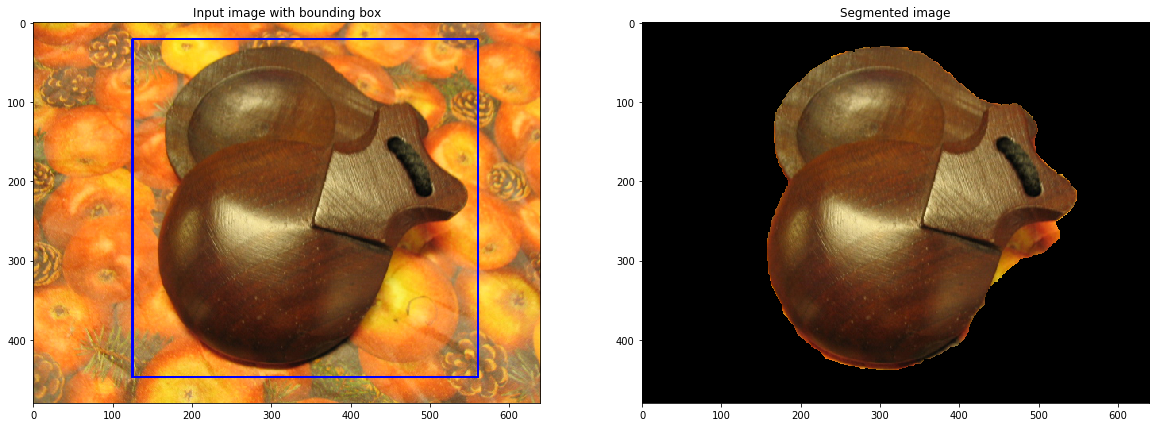

In [16]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

### itr = 3

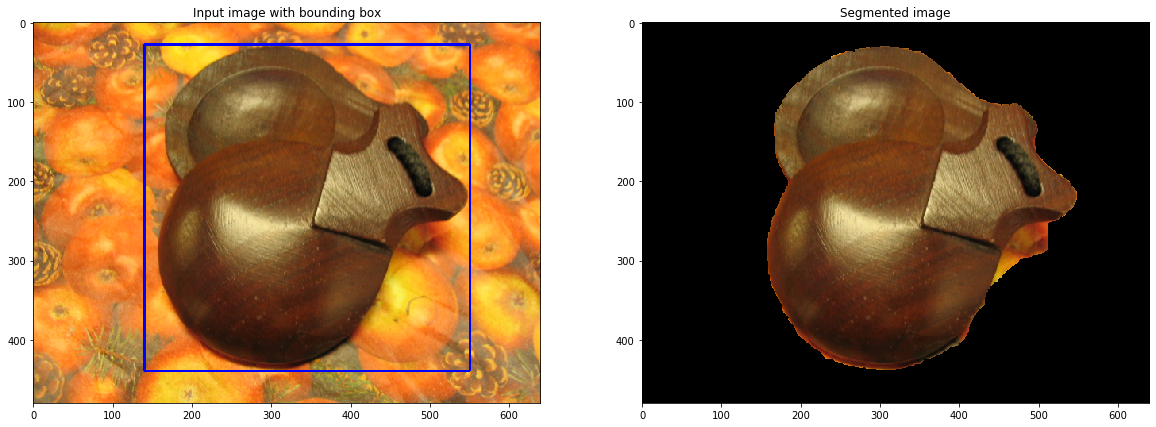

In [18]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

### Observation:
    By increasing number of iterations we get more finer segmentation but after 3-5 iteration it gets nearly convergered.

## 2. Number of mixture components in GMM (K)

### K=3

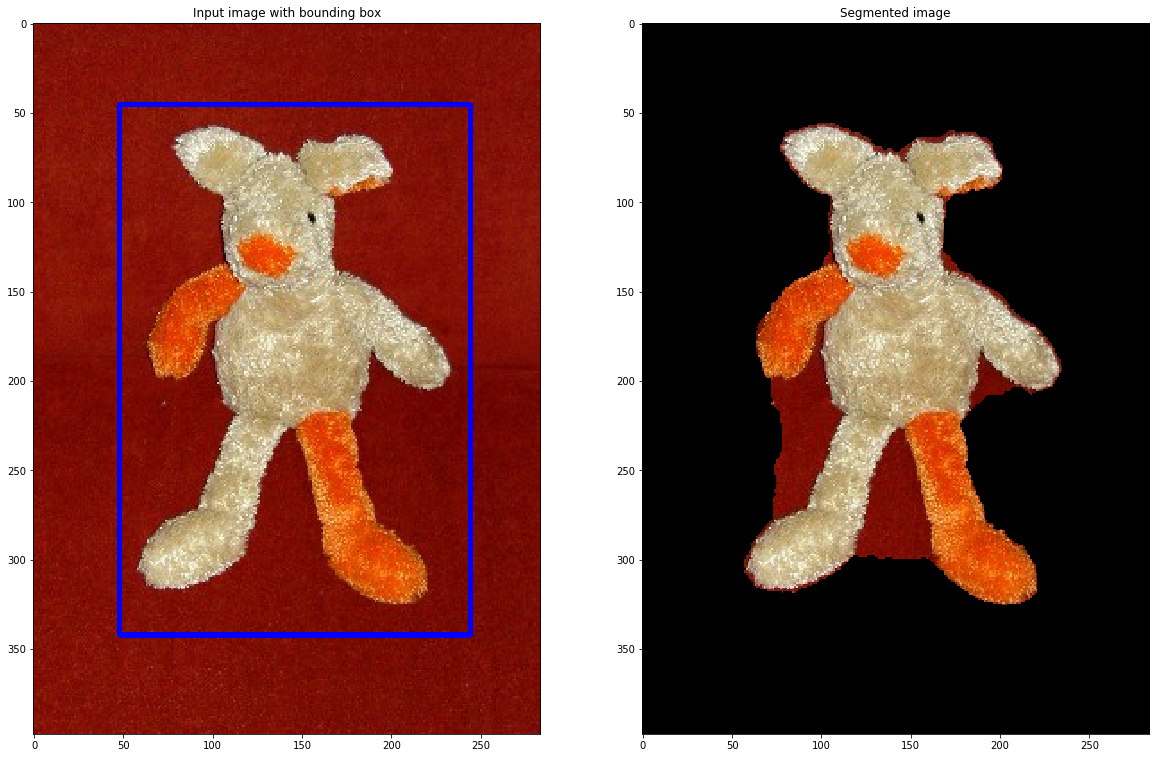

In [22]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

### K=5 (default)

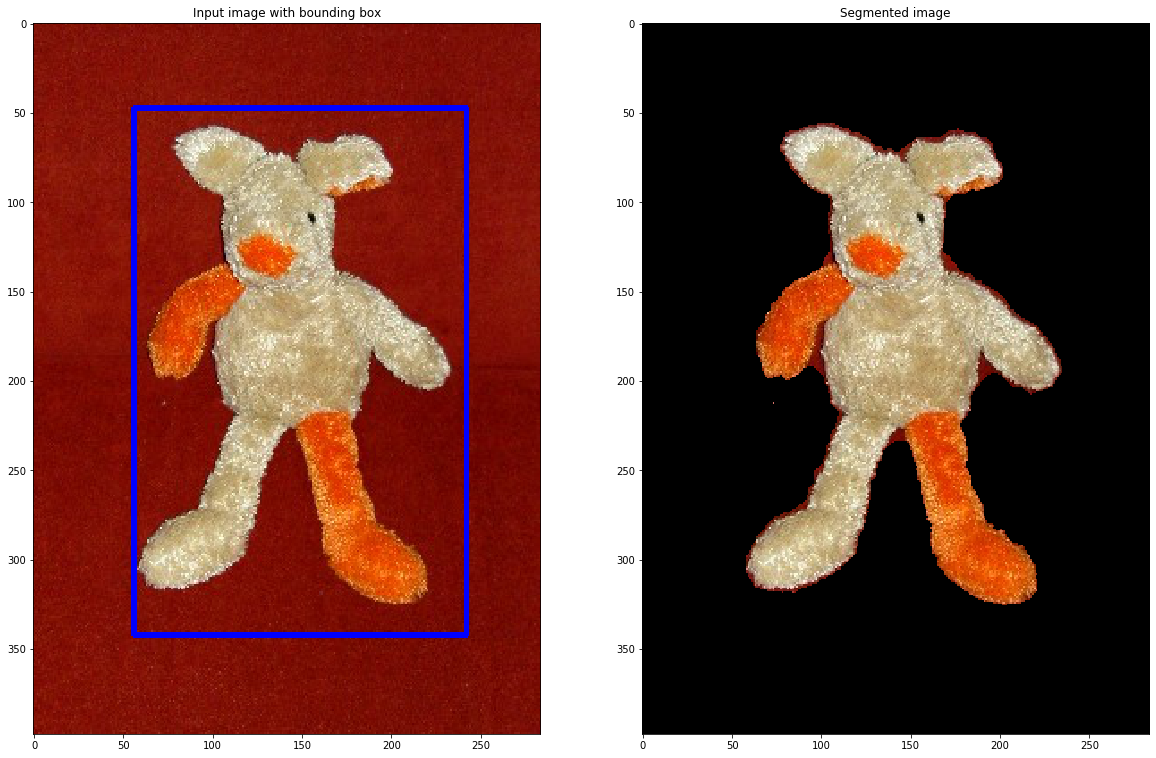

In [24]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

### K=10

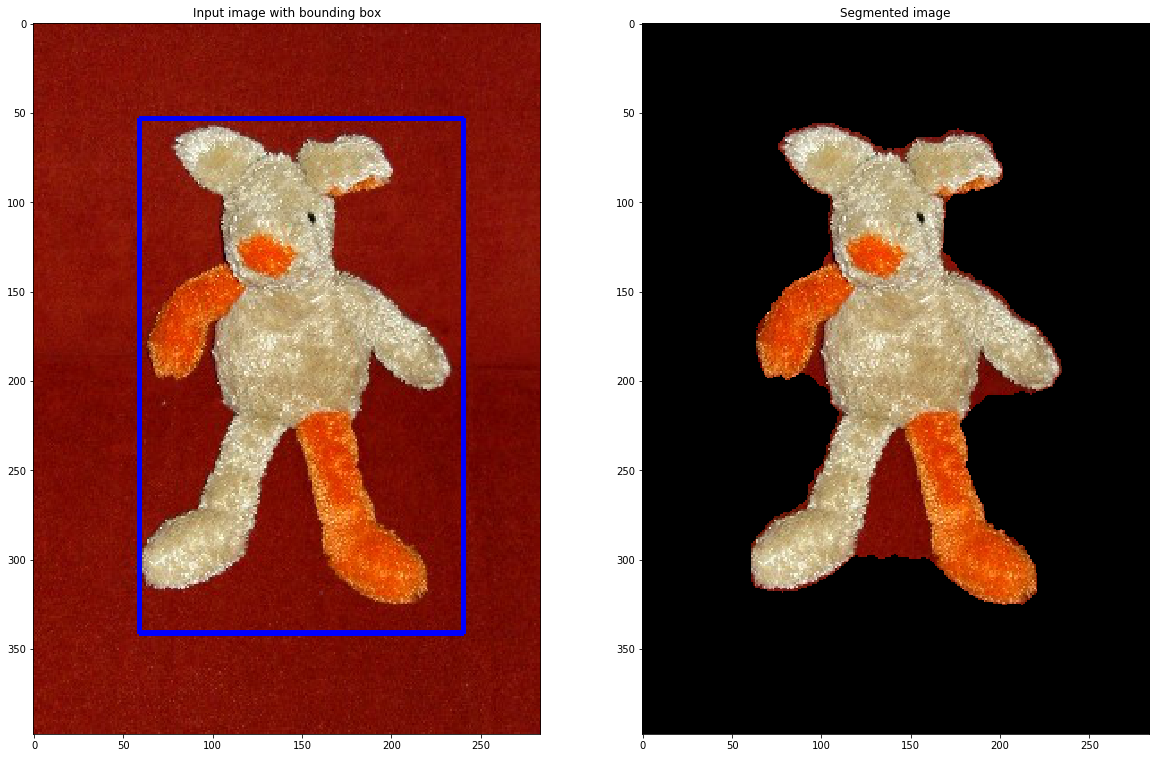

In [28]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

### Observation:
    When K=3, we get some background part in the segmented image
    When K=5, we get good segmentation 
    When K=10, again we get some background part in the segmented image

## 3. Choice of Gamma

### gamma = 30

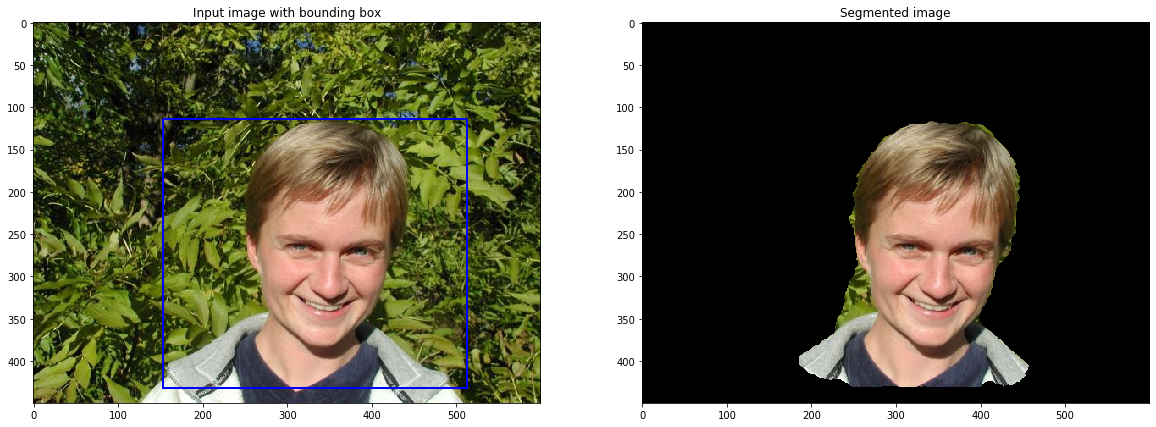

In [30]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

### gamma = 50 (default)

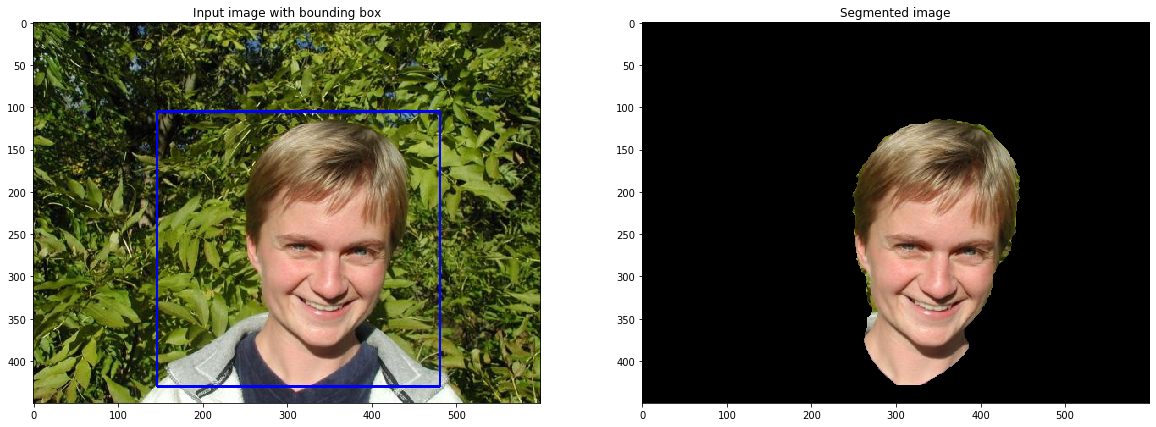

In [32]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

### gamma = 100

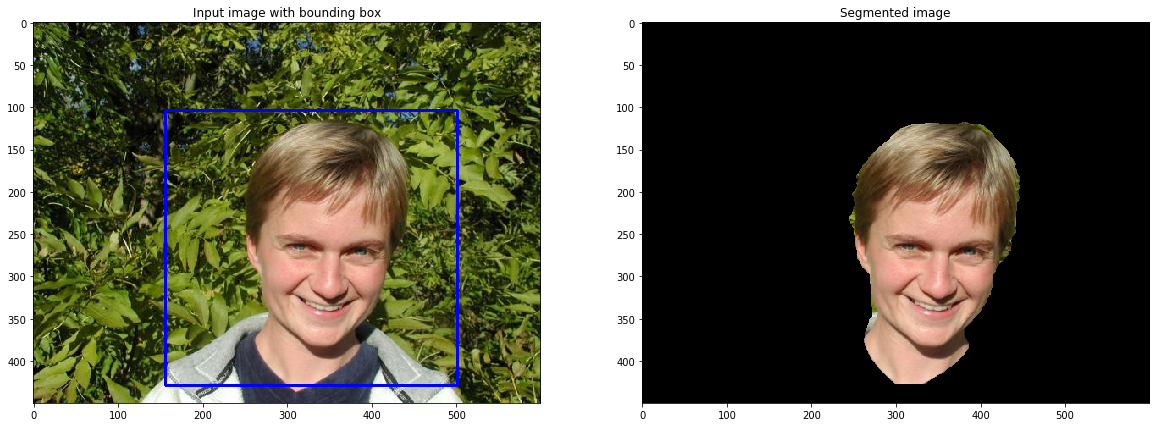

In [34]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

### Observation:
    By increasing gamma, we get more fine results. from gamma = 50, we get good segmentation.

## 4-neighbourhood vs 8-neighbourhood

### 4-neighbourhood

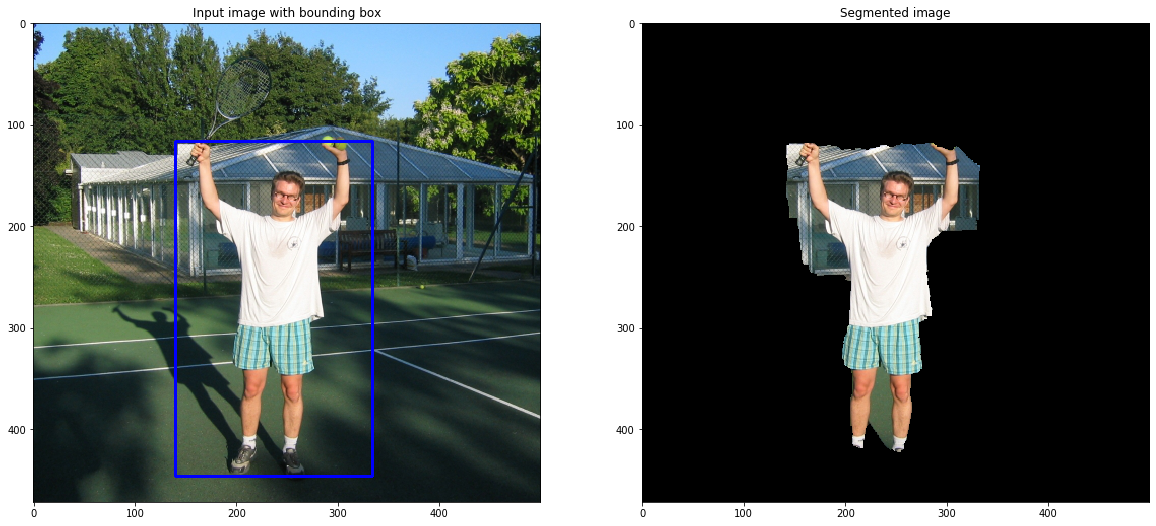

In [40]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

### 8-neighbourhood

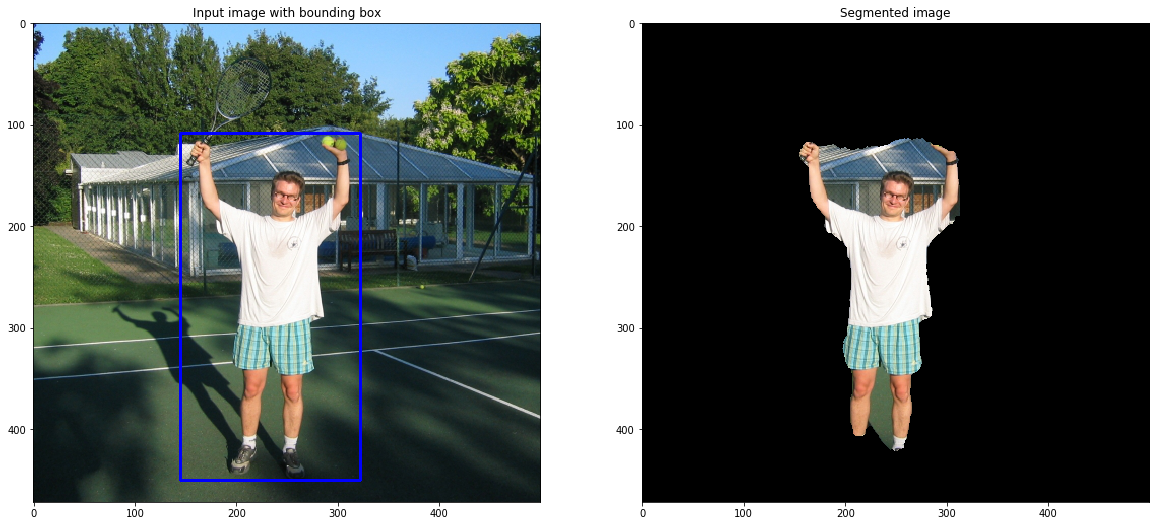

In [42]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

### Observation:
    Both 4-connected and 8-connected outputs are almost similar, but in this image, we get better with the 8-connected neighbours.

### User Editing

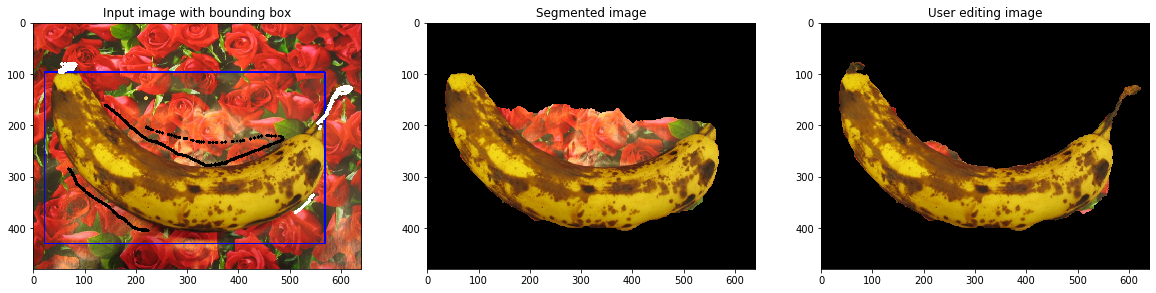

In [55]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
output1 = cv2.cvtColor(output1,cv2.COLOR_BGR2RGB)
plt.subplot(131),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(132),plt.title("Segmented image"), plt.imshow(output1)
plt.subplot(133),plt.title("User editing image"), plt.imshow(output)
plt.show()

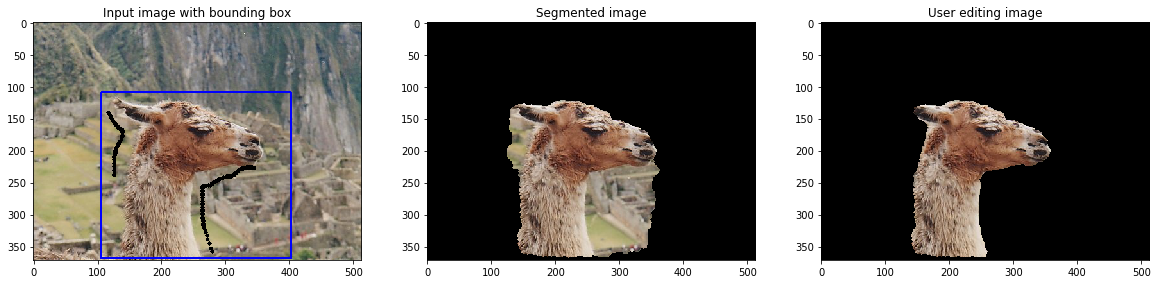

In [57]:
plt.figure(figsize=(20, 20))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
output1 = cv2.cvtColor(output1,cv2.COLOR_BGR2RGB)
plt.subplot(131),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(132),plt.title("Segmented image"), plt.imshow(output1)
plt.subplot(133),plt.title("User editing image"), plt.imshow(output)
plt.show()

### Classic image for grabcut with user input

In [75]:
# !ls ../images
# os.listdir('../images')
images = [
 'flower.jpg',
 'book.jpg',
 'grave.jpg',
]

In [76]:
output_images = []

In [77]:
for image in images:
    filename = '../images/' + image               # Path to image file
    itrs = 1
    K = 5
    gamma = 50
    img, output, output1 = run(filename, itrs, K, gamma, 'c-8')
    output_images.append([img.copy(), output.copy()])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

(1076852, 2)
(1076852,)
Draw the rectangle first.
In
270000 0 0 0
170592 99408 0 0
{'color': [255, 255, 255], 'val': 2}
0
0
170592
99408
52973
217029
0  Done
Done
(1225442, 2)
(1225442,)
Draw the rectangle first.
In
307200 0 0 0
79536 227664 0 0
{'color': [255, 255, 255], 'val': 2}
0
0
79536
227664
140345
166857
0  Done
Done
(1076852, 2)
(1076852,)
Draw the rectangle first.
In
270000 0 0 0
204583 65417 0 0
{'color': [255, 255, 255], 'val': 2}
0
0
204583
65417
37864
232138
0  Done
Done


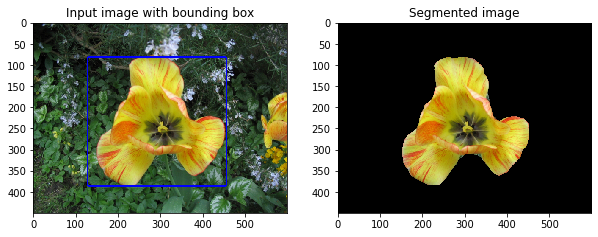

In [80]:
plt.figure(figsize=(10, 10))
img = cv2.cvtColor(output_images[0][0],cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output_images[0][1],cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

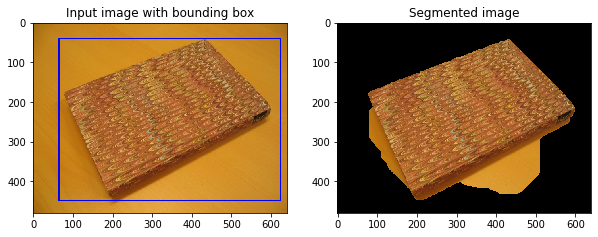

In [81]:
plt.figure(figsize=(10, 10))
img = cv2.cvtColor(output_images[1][0],cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output_images[1][1],cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

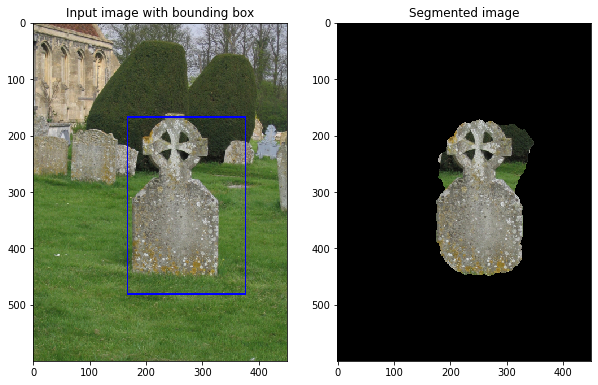

In [82]:
plt.figure(figsize=(10, 10))
img = cv2.cvtColor(output_images[2][0],cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output_images[2][1],cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.title("Input image with bounding box"), plt.imshow(img)
plt.subplot(122),plt.title("Segmented image"), plt.imshow(output)
plt.show()

        For some noisy image, we need user input or apply MRF.